# Dev notebook

To begin, we're using this dev notebook to develop and test new functionality. Here we have an interactive coding environment, a battery of 'tests', and examples below. All roled into one.

When things get more complicated we can break this out into an example notebook, and real pytests.

## Object Classes

copied from factum\lib\objects.py

In [1]:
class DataFact():
    '''
    basically a static function that has no inputs and no caching, it returns data.
    it might have code to first get that data from a database in it, but it
    does not have inputs passed to it.

    features:
        - no inputs (does not rely on other nodes)
        - no caching (runs it's computations everytime it's called)
    '''

    def __init__(
        self,
        transform: callable = None,
        name: str = None,
        **kwargs
    ):
        '''
        helpful kwargs may be:
            kind: str (for example: 'data', 'view', 'task', 'transform', etc.)
            meta: dict (a good place to store meta data)
        '''
        self.set_transform(transform)
        self.set_name(name)
        self.latest = None
        self.outsig = None
        self.__dict__.update({
            k: v for k, v in kwargs.items()
            if k not in dir(Fact)})

    @staticmethod
    def sha256(data):
        import hashlib
        return hashlib.sha256(data.encode('utf-8')).hexdigest()

    def clear(self):
        self.latest = None
        self.outsig = None

    def set_name(self, name: str):

        def generate_random_name(length: int = 12):
            import random
            import string
            letters = string.ascii_lowercase
            return ''.join(random.choice(letters) for i in range(length))

        self.name = name or (
            self.transform.__name__
            if self.transform.__name__ != 'transform'
            else (
                self.__repr__().split()[0].split('.')[-1]
                if self.__repr__().split()[0].split('.')[-1] not in ['Fact', 'DataFact', 'MindlessFact', 'Fact']
                else generate_random_name(12)))

    def set_transform(self, function: callable = None):
        if function is None:
            return
        if function.__code__.co_varnames[0] == 'self':
            self.transform = function.__get__(self)
        else:
            self.transform = function

    def add_method(self, function: callable):
        '''
        a way to add other methods to the instance for transform to call into...
        ideally they would start with _ and would not rely on self.
        merely for code management.
        '''
        if function.__code__.co_varnames[0] == 'self':
            exec(f'self.{function.__name__} = function.__get__(self)')
        else:
            exec(f'self.{function.__name__} = function')

    def run(self, *args, **kwargs):
        return self.function()

    def function(self):
        import collections
        output = self.transform()
        if isinstance(output, collections.Hashable):
            this_hash = DataFact.sha256(output)
            if this_hash != self.outsig:
                self.outsig == this_hash
                self.set_latest()
        else:
            self.set_latest()
        return output

    def set_latest(self):
        import datetime as dt
        self.latest = dt.datetime.utcnow().timestamp()

    def transform(self):
        ''' main '''
        return self.name

    def visualization(self):
        ''' merely return the data itself '''
        return self.transform()


class MindlessFact(DataFact):
    '''
    basically a function that is responsible for
    getting its own inputs, has no caching functionality.

    features:
        - has inputs (relies on other nodes for data)
        - no caching (must call inputs)
        - no caching (must computations)
    '''

    def __init__(
        self,
        transform: callable = None,
        inputs: dict = None,
        name: str = None,
        **kwargs
    ):
        '''
        helpful kwargs may be:
            kind: str (for example: 'data', 'view', 'task', 'transform', etc.)
            meta: dict (a good place to store meta data)
        '''
        self.set_inputs(inputs=inputs or {})
        super(MindlessFact, self).__init__(transform, name, **kwargs)

    def set_inputs(self, inputs: dict):
        self.inputs = inputs

    def run(self, *args, **kwargs):
        '''
        might use gas in kwargs. we always aquire because we have no cache
        we garbage collect the inputs by calling the function directly.
        '''
        if len(args) >= 1:
            args[0] -= 1
        if 'gas' in kwargs.keys() and kwargs.get('gas', 0) > 0:
            kwargs['gas'] -= 1
        return self.function(*args, **kwargs)

    def function(self, *args, **kwargs):
        import collections
        output = self.transform(**{
            name: function_object.run(*args, **kwargs)
            for name, function_object in self.inputs.items()})
        if isinstance(output, collections.Hashable):
            this_hash = MindlessFact.sha256(output)
            if this_hash != self.outsig:
                self.outsig == this_hash
                self.set_latest()
        else:
            self.set_latest()
        return output

    def transform(self, **kw):
        ''' main '''
        return self.name

    def visualize(self, size=(8,5)):
        '''
        minimal
        indications:
            color: root node, parent nodes, ancestor nodes
            size: cached
            (color shape and size should be attribute of object, not derived here that way
            you could ask a base type node to graph and it will ask ancestors for these details,
            you could have a coordinating node which holds the mapping that they will return to you...)
            shape: <not implemented, could be kind>
        missing:
            easthetics: uniformly layout
            functionality: save to file
            indicators: namespacing, kind, time cost, popularity, etc...
        '''

        def graph_heritage(current, seen):
            seen.append(current)
            parents = [v for v in current.inputs.values()]
            for parent in parents:
                if not graph.has_node(parent.name):
                    graph.add_node(parent.name)
                    sizes.append(1200 if parent.latest else 600)
                    colors.append(
                        '#d7a9e3'
                        if parent in [v for v in self.inputs.values()]
                        else '#8bbee8')
                ancestors.append((parent.name, current.name))
                if parent not in seen:
                    graph_heritage(current=parent, seen=seen)

        import networkx as nx
        import matplotlib.pyplot as plt
        graph = nx.DiGraph()
        colors = []
        sizes = []
        ancestors = []
        if not graph.has_node(self.name):
            graph.add_node(self.name)
            sizes.append(1200 if self.latest else 600)
            colors.append('#a8d5ba')
        graph_heritage(current=self, seen=[])
        graph.add_edges_from(ancestors, weight=1)
        pos = nx.spring_layout(graph)
        nx.draw(graph, pos, with_labels=True, node_color=colors, node_size=sizes)

        # gives all nodes a border
        #ax= plt.gca()
        ##print(ax.collections[0])
        ##return ax.collections
        #ax.collections[0].set_edgecolor("#000000")
        #plt.axis('off')

        plt.rcParams["figure.figsize"] = size
        plt.show()


class Fact(MindlessFact):
    '''
    basically a function that is responsible for
    getting its own inputs and remembering its own outputs

    features:
        - has inputs (relies on other nodes for data)
        - has cached output
        - has timestamp of last time it ran
    '''

    def __init__(
        self,
        transform: callable = None,
        inputs: dict = None,
        name: str = None,
        **kwargs
    ):
        '''
        helpful kwargs may be:
            prefer_cache: bool (referenced in self.run)
            kind: str (for example: 'data', 'view', 'task', 'transform', etc.)
            meta: dict (a good place to store meta data)
        '''
        self.clear(memory=True)
        super(Fact, self).__init__(transform, inputs, name, **kwargs)


    def set_inputs(self, inputs: dict):
        self.inputs = inputs
        self.ranutc = {name: None for name in self.inputs.keys()}

    def clear(self, memory: bool = False):
        self.latest = None
        if memory:
            self.output = None

    def save(self, folder: str = None):
        if self.latest is None:
            return
        self.to_binary(folder)

    def restore(self, folder: str = None):
        if self.latest is None:
            return
        self.from_binary(folder)

    def to_binary(self, folder: str = None):
        import os
        import pickle
        folder = folder or os.getcwd()
        os.makedirs(folder, mode=0o777, exist_ok=True)
        with open(os.path.join(folder, self.name, 'output'), mode='wb') as f:
            pickle.dump(self.output, f)
        with open(os.path.join(folder, self.name, 'inputs'), mode='wb') as f:
            pickle.dump(self.inputs, f)
        with open(os.path.join(folder, self.name, 'latest'), mode='wb') as f:
            pickle.dump(self.latest, f)

    def from_binary(self, folder: str = None):
        import os
        import pickle
        folder = folder or os.getcwd()
        os.makedirs(folder, mode=0o777, exist_ok=True)
        with open(os.path.join(folder, self.name, 'output'), mode='rb') as f:
            self.output = pickle.load(f)
        with open(os.path.join(folder, self.name, 'inputs'), mode='rb') as f:
            self.inputs = pickle.load(f)
        with open(os.path.join(folder, self.name, 'latest'), mode='rb') as f:
            self.latest = pickle.load(f)

    def run(
        self,
        gas: int = 0,
        condition: str = None,
        force: bool = False,
        **kwargs
    ):
        '''
        `run()` tells asks the Fact to return cache if the cache is available
        and up-to-date, or, if it isn't, gather the required inputs and execute
        the function defined as 'transform'.

        `gas` can specify how far back in the network we should look to verify
        that our cache is up-to-date. valid values range from -1 and up:
        -1 - infinite gas (DAGs only!) forces execution of all ancestors and self
        0 - if cache: cache, else: get inputs, do function, save as cache
        1 - request cached inputs and run functionality
        2 - request non-cached inputs and run functionality
        3 - request that inputs request non-cached inputs and recalculate...
        4+ - so on and so forth...

        condition is an override on gas and allows one to specify function
        execution according to the condition itself. for instance one may want
        the function to execute if the object provides up-to-date source data.
        this could be accomplished by providing the following keyword argument:
        `condition="self.kind == 'data'"`

        force means you want the function to run if it has gas to do so.
        '''
        if self.gather(gas) is None:
            gas = gas if gas <= 0 else gas -1
            self.function(**{
                name: fact.run(gas=gas, condition=condition, force=force, **kwargs)
                for name, fact in self.inputs.items()})
        elif condition is not None:
            try:
                evaluated = eval(condition)
            except Exception as e:
                evaluated = False
            if evaluated:
                gas = gas if gas <= 0 else gas -1
                self.function(**{
                    name: fact.run(gas=gas, condition=condition, force=force, **kwargs)
                    for name, fact in self.inputs.items()})
        elif gas == -1:
            self.function(**{
                name: fact.run(gas=gas, condition=condition, force=force, **kwargs)
                for name, fact in self.inputs.items()})
        elif gas > 0 and force:
            gas = gas if gas <= 0 else gas -1
            self.function(**{
                name: fact.run(gas=gas, condition=condition, force=force, **kwargs)
                for name, fact in self.inputs.items()})
        return self.get()

    def gather(self, gas: int = 0):
        ''' gets the latest timestamp out of everything '''
        if gas != 0 and self.latest is not None:
            gas = gas if gas <= 0 else gas -1
            for name, fact in self.inputs.items():
                if hasattr(fact, 'gather'):
                    value = fact.gather(gas)
                else:
                    value = fact.latest
                if value is None or value > self.latest:
                    return None
        return self.latest

    def get(self):
        return self.output

    def function(self, **kwargs):
        temp = self.output
        self.output = self.transform(**kwargs)
        if temp != self.output:
            self.set_latest()

    def transform(self, **kw):
        ''' main '''
        return self.output


## Original Fact Object

This original version was before it was converted to an inheritance structure. It both saved it's own output and it's inputs, making it simpler and easier to check if they've changed, but less memory efficient. the new version only remembers it's own output and uses timestamps of when things last ran to determin if it needs to run again. this is here for reference only, and will be removed at some point.

In [2]:
class OriginalFunction():
    '''
    basically a function that is responsible for
    getting its own inputs and executes everytime
    often used as input nodes
    '''

    def __init__(
        self,
        inputs: dict = None,
        name: str = None,
        transform: callable = None,
        **kwargs
    ):
        self.set_inputs(inputs=inputs or {})
        self.set_transform(transform)
        self.set_name(name)
        self.clear(memory=True)
        self.__dict__.update({
            k: v for k, v in kwargs.items()
            if k not in dir(Function)})

    def set_name(self, name: str):
        self.name = name or (
            self.transform.__name__
            if self.transform.__name__ != 'transform'
            else self.__repr__().split()[0].split('.')[-1])
    
    def set_inputs(self, inputs: dict):
        self.inputs = inputs
        self.kwargs = {name: None for name in self.inputs.keys()}

    def clear(self, memory: bool = False):
        self.cached = False
        self.getout = False
        if memory:
            self.output = None
            self.latest = None

    def run(
        self,
        gas: int = 1,
        condition: str = None,
        prefer_cache: bool = None,
        verbose: bool = False
    ):
        '''
        gas can specify if we should pull from cache or not in this way:
        -1 - infinite gas (DAGs only!)
        0 - if cache: cache, else: get inputs, do function, save as cache
        1 - request cached inputs and run functionality (default)
        2 - request non-cached inputs and run functionality
        3 - request that inputs request non-cached inputs and recalculate...
        4+ - so on and so forth...

        condition is an override on gas and allows one to specify function
        execution according to the condition itself. for instance one may want
        the function to execute if the object provides up-to-date source data.
        this could be accomplished by providing the following keyword argument:
            `condition="self.kind == 'data'"`

        prefer_cache means even if there is enough gas to run the function,
        avoid doing so if the aquired inputs match the inputs used the last
        time the function ran. it is an optimization for pure functions.
        '''
        prefer_cache = (
            prefer_cache if prefer_cache is not None else (
                self.prefer_cache if hasattr(self, 'prefer_cache') else False))
        if condition is not None and eval(condition):
            self.function()
        elif gas == 0 and self.cached:
            pass
        else:
            if gas == 0 and not self.cached:
                self.aquire(gas=0)
            elif gas >= 1:
                self.aquire(gas=gas - 1)
            elif gas == -1:
                self.aquire(gas)
            else:
                self.aquire(0)
            if (not self.cached or
                not prefer_cache or
                self.latest != self.kwargs
            ):
                self.function()
        return self.get()

    def aquire(self, gas: int = 0, condition: str = None):
        for name, function_object in self.inputs.items():
            self.kwargs[name] = function_object.run(gas, condition)

    def get(self):
        return self.output

    def visualize(self, size=(8,5)):
        '''
        minimal, no uniformly layout, unable to save to file, no namespacing
        and no indications such as cached, kind, cost in time, or popularity...
        '''

        def graph_heritage(current, seen):
            seen.append(current)
            parents = [v for v in current.inputs.values()]
            for parent in parents:
                if not graph.has_node(parent.name):
                    graph.add_node(parent.name)
                    sizes.append(1200 if parent.cached else 600)
                    colors.append(
                        '#d7a9e3'
                        if parent in [v for v in self.inputs.values()]
                        else '#8bbee8')
                ancestors.append((parent.name, current.name))
                if parent not in seen:
                    graph_heritage(current=parent, seen=seen)

        import networkx as nx
        import matplotlib.pyplot as plt
        graph = nx.DiGraph()
        colors = []
        sizes = []
        ancestors = []
        if not graph.has_node(self.name):
            graph.add_node(self.name)
            sizes.append(1200 if self.cached else 600)
            colors.append('#a8d5ba')
        graph_heritage(current=self, seen=[])
        graph.add_edges_from(ancestors, weight=1)
        pos = nx.spring_layout(graph)
        nx.draw(graph, pos, with_labels=True, node_color=colors, node_size=sizes)

        # gives all nodes a border 
        #ax= plt.gca()
        ##print(ax.collections[0])
        ##return ax.collections
        #ax.collections[0].set_edgecolor("#000000")
        #plt.axis('off')
        
        plt.rcParams["figure.figsize"] = size
        plt.show()

    def function(self):
        self.latest = self.kwargs
        self.output = self.transform(**self.kwargs)
        self.cached = True

    def transform(self, **kw):
        ''' main '''
        return self.output

    def set_transform(self, function: callable = None):
        if function is None:
            return
        if function.__code__.co_varnames[0] == 'self':
            self.transform = function.__get__(self)
        else:
            self.transform = function
    
    def add_method(self, function: callable):
        ''' 
        a way to add other methods to the instance for transform to call into... 
        ideally they would start with _ and would not rely on self. 
        merely for code management.
        '''
        if function.__code__.co_varnames[0] == 'self':
            exec(f'self.{function.__name__} = function.__get__(self)')
        else:
            exec(f'self.{function.__name__} = function')

# Examples

Here's one way to make an Fact. This is not the typical way, unless perhaps you wanted to create a fact type that has special functionality, such as might be the case in an ETL process where some nodes are extract nodes, others transform nodes, and others load nodes, and others still might even be visualize nodes, etc.

In [3]:
class A(Fact):
    def transform(self, **kw):
        print('A running!')
        return 1

In [4]:
a = A(name='Alpha')

In [5]:
a.name

'Alpha'

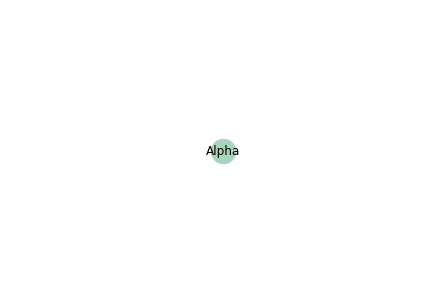

In [6]:
a.visualize()

In [7]:
a.inputs

{}

In [8]:
print(a.output)

None


lets tell the function to run by giving it one unit of gas.

In [9]:
a.run(1)

A running!


1

Since it remembers it's output if we give it a unit of gas again it will not run the function, it will just return the latest results

In [10]:
a.run(1)

1

Let's force it to run (if it has the gas to do so)

In [11]:
a.run(1, force=True)

A running!


1

In [12]:
print(a.output)

1


lets make another

In [13]:
class B(Fact):
    def transform(self, **kw):
        print('B running!')
        return 2

In [14]:
b = B(name='Beta')

lets actually no run it right now

In [15]:
# b.run()

In [16]:
print(b.output)

None


Lets make another, this time we wont make a whole new class, we'll use the class and attach a method to it

In [17]:
def c_transform(self, **kw):
    print('C running!')
    return self.kwargs['A'] + self.kwargs['B'] # doesn't work, object doesn't remember kwargs anymore

def c_transform_without_self(**kw):
    print('C running!')
    return kw['A'] + kw['B']

In [18]:
c = Fact(
    inputs={'A': a, 'B': b},
    transform=c_transform_without_self,  
    #transform=c_transform,  # also valid
)

# c.set_transform(c_transform)  # also valid

we didn't specify a name so the function name becomes it's name

In [19]:
c.transform.__name__

'c_transform_without_self'

In [20]:
c.name

'c_transform_without_self'

notice Alpha node is bigger than Beta node, that's because it has cached data

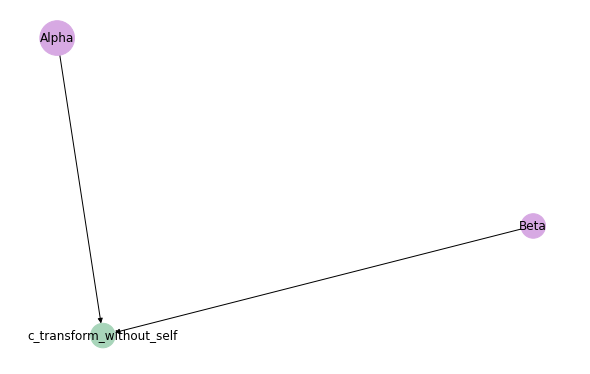

In [21]:
c.visualize()

Since we never ran B, C will realize we have to and will run it even though we didn't give it any gas

In [22]:
c.run()

B running!
C running!


3

lets run it again with -1 gas to indicate infinite gas, and forcing run of everything

In [23]:
c.run(-1)

A running!
B running!
C running!


3

In [24]:
c.run(1)

3

lets make another one, we can name inputs anything internally.

In [25]:
class D(Fact):
    def transform(self, **kw):
        print('D running!')
        return _layer_1(**kw)

In [26]:
d = D(inputs={'M': c})

since we didn't name it and didn't give it's transformation function a name it takes the name of the class

In [27]:
d.name

'D'

we can add methods to the instance that transform function can call

In [28]:
def _layer_1(**kw):
    return kw['M']+1
d.add_method(_layer_1)

root in question is green, parents are purple and ancestors are blue

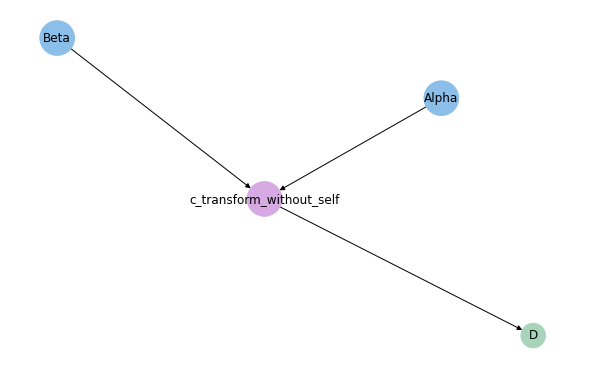

In [29]:
d.visualize()

lets run it, everything else has been cached already

In [30]:
d.run()

D running!


4

In [31]:
d.run(0)

4

In [32]:
d.run(1)

4

In [33]:
d.run(2, force=True)

C running!
D running!


4

In [34]:
d.run(3)

4

In [35]:
d.run(-1)

A running!
B running!
C running!
D running!


4

lets make one more

In [36]:
def transform(**kw):
    print('E running!')
    return kw['A'] + kw['D']

In [37]:
e = Fact(
    inputs={'A': a, 'D': d},
    transform=transform,
    kind='Viz')

we didn't give it a name, we didn't give transform a new name, we didn't give the class a new name, so it will make one up

In [38]:
e.name

'ljwzekivdxbx'

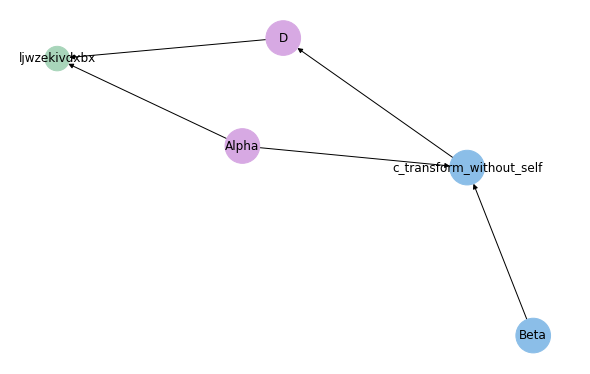

In [39]:
e.visualize()

In [40]:
e.run()

E running!


5

lets tell e to refresh it's dataset if a condition is met

In [41]:
e.run()

5

In [42]:
e.run(condition="self.kind == 'Viz'")

E running!


5

# recursion

The following structure is a hash structure it contains one and only one loop. We can't use `gas=-1` because it will loop forever. This is fine in this case; we know they converge.

In [43]:
class X(Fact):
    def transform(self, **kw):
        if kw['Y'] < 10:
            i = kw['Y']+1
        else: 
            i = kw['Y']
        print(self.name, 'running! returning', i)
        return i
    
    
class Y(Fact):
    def transform(self, **kw):
        if kw['X'] < 6:
            i = kw['X']+1
        else: 
            i = kw['X']
        print(self.name, 'running! returning', i)
        return i
    
    
class Z(Fact):
    def transform(self, **kw):
        i = kw['Y']+1
        print(self.name, 'running! returning', i)
        return i

In [44]:
x = X(name='x')
y = Y(inputs={'X': x}, name='y')
z = Z(inputs={'Y': y}, name='z')
x.set_inputs(inputs={'Y': y})

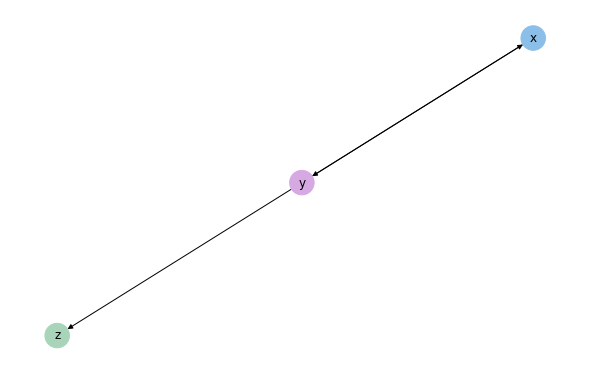

In [45]:
z.visualize()

notice, it counts up until X=6 then Y stops incrementing, but X continues to increment until it reaches 10, then, it still has gas left over so it continues to call each other until the gas runs out and the answer is returned to Z which runs it's own function that increments that answer by 1 and returns 11. 

This is a loop completely governed by gas, and the fact that one member of the loop was seeded with a default value. Since each function has internal state, being an object itself, loop behavior could be governed by internal counters, theoretically.

As you can see, creating a loop is difficult to manage and dangerous to execute. So it's best to make DAGs in general, but recursive relationships are possible. In fact, in an idealized parallel version of this design there would exist a main loop which runs forever, keeping the program alive.

In [46]:
import datetime as dt
x.output = 0
x.latest = dt.datetime.utcnow().timestamp()

In [47]:
z.run(20)

y running! returning 1
x running! returning 2
y running! returning 3
x running! returning 4
y running! returning 5
x running! returning 6
y running! returning 6
x running! returning 7
y running! returning 7
x running! returning 8
y running! returning 8
x running! returning 9
y running! returning 9
x running! returning 10
y running! returning 10
x running! returning 10
y running! returning 10
x running! returning 10
y running! returning 10
z running! returning 11


11